In [3]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from python_speech_features import mfcc, logfbank
import librosa
import csv

In [4]:
waveFile = r"C:\Users\Saad KOUKOUS\Documents\Projet5A\DCASE_2023_Challenge_Task_7_Dataset\dev"
items = os.listdir(waveFile)
items

['dog_bark',
 'footstep',
 'gunshot',
 'keyboard',
 'moving_motor_vehicle',
 'rain',
 'sneeze_cough']

In [5]:
fi= open('data_labeled.csv','w')
writer = csv.writer(fi)
writer.writerow(['index','label','length'])
for item in items:
    for f in os.listdir(waveFile+"\\"+item):
        
        rate , signal = wavfile.read(waveFile+'\\'+item+'\\'+f)
        writer.writerow([item+"\\"+f,item,signal.shape[0]/rate])
        # print(f)
fi.close()

In [78]:
df = pd.read_csv('data_labeled.csv')
df.set_index('fname',inplace =True)

In [34]:
def plot_signals(signals):
    fig,axes =plt.subplots(nrows=2,ncols=4,sharex=False,sharey=True,figsize=(20,5))
    fig.suptitle('Time Series',size=16)
    
    i=0
    for x in range(2):
        for y in range(4):
            if(x==1 and y ==3):
                break
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

In [32]:
def plot_fft(fft):
    fig,axes =plt.subplots(nrows=2,ncols=4,sharex=False,sharey=True,figsize=(20,5))
    fig.suptitle('fourier transforms',size=16)
    # fig.
    i=0
    for x in range(2):
        for y in range(4):
            if(x==1 and y ==3):
                break
            data=list(fft.values())[i]
            Y,freq = data[0],data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq,Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1
            

In [37]:
def plot_fbank(fbank):
    fig,axes =plt.subplots(nrows=2,ncols=4,sharex=False,sharey=True,figsize=(20,5))
    fig.suptitle('filter Bank Coefficents',size=16)
    i=0
    for x in range(2):
        for y in range(4):
            if(x==1 and y ==3):
                break
            axes[x,y].set_title(list(fbank.keys())[i])
            axes[x,y].imshow(list(fbank.values())[i],cmap='hot',interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

In [38]:
def plot_mfccs(mfccs):
    fig,axes =plt.subplots(nrows=2,ncols=4,sharex=False,sharey=True,figsize=(20,5))
    fig.suptitle('Mel Frequency Cepstrum Coefficients',size=16)
    i=0
    for x in range(2):
        for y in range(4):
            if(x==1 and y ==3):
                break
            axes[x,y].set_title(list(mfccs.keys())[i])
            axes[x,y].imshow(list(mfccs.values())[i],cmap='hot',interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i+=1

In [26]:
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].sum()
class_dist

label
dog_bark                2468.0
footstep                2812.0
gunshot                 3108.0
keyboard                3200.0
moving_motor_vehicle    2324.0
rain                    2964.0
sneeze_cough            2524.0
Name: length, dtype: float64

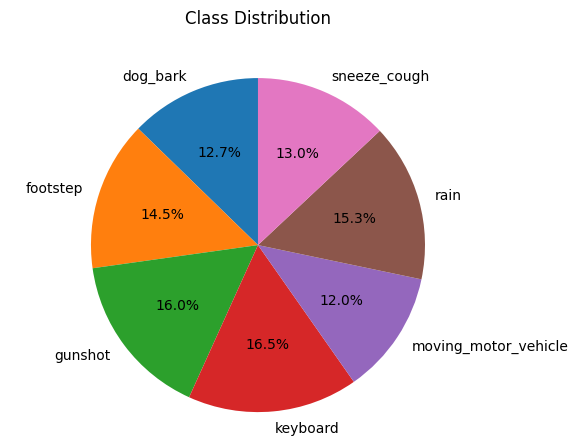

In [27]:
fig,ax= plt.subplots()
ax.set_title('Class Distribution',y=1.08)
ax.pie(class_dist,labels=class_dist.index,autopct='%1.1f%%',shadow=False,startangle=90)
ax.axis('equal')
plt.show()
df.reset_index(inplace=True)

In [20]:
def calc_fft(y,rate):
    n=len(y)
    freq = np.fft.rfftfreq(n,d=1/rate)#real fft get fft values 
    Y = abs(np.fft.rfft(y)/n)#fft return complex we need just the abs
    return (Y,freq)

In [21]:
signals={}
fft = {}
fbank ={}
mfccs = {}

In [53]:
for classe in classes:
    wav_F = df[df.label == classe].iloc[0,0]
    signal,rate = librosa.load(waveFile+'\\'+wav_F,sr = 22050)
    signals[classe]=signal
    fft[classe] = calc_fft(signal,rate)#calculate fft
    
    bank = logfbank(signal[:rate],rate,nfilt = 26,nfft=551).T#speech_feachure nfft sr/40
    fbank[classe] =bank
    mel = mfcc(signal[:rate],rate,numcep=13,nfilt=26,nfft=551).T
    mfccs[classe]=mel

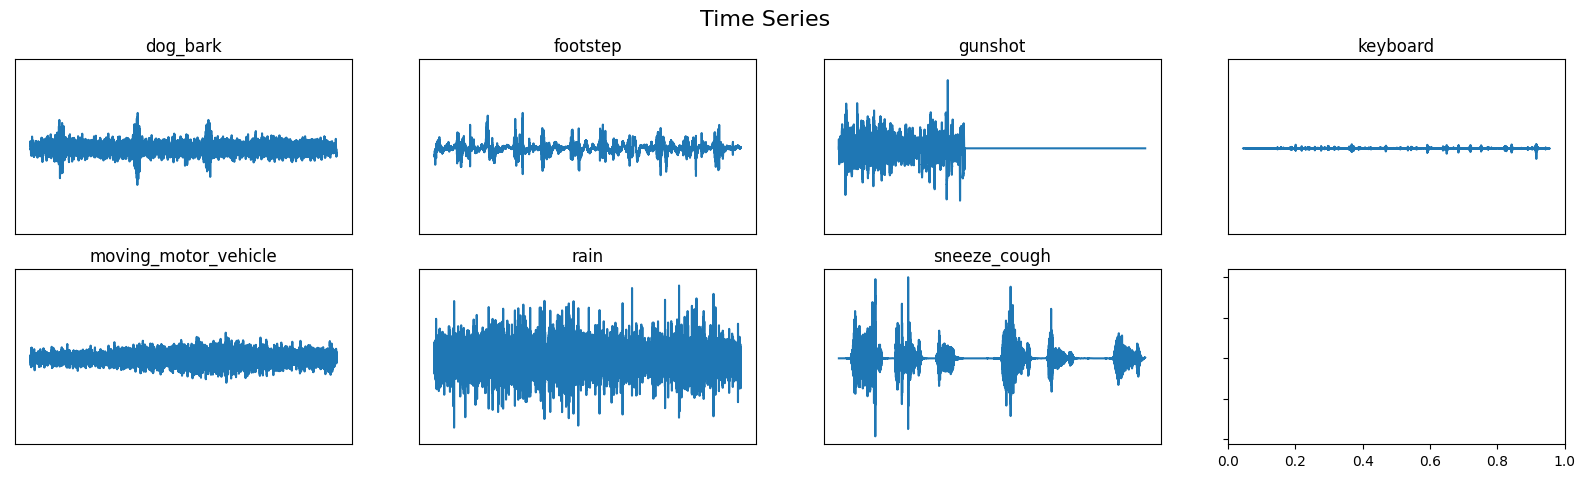

In [54]:
plot_signals(signals)
plt.show()

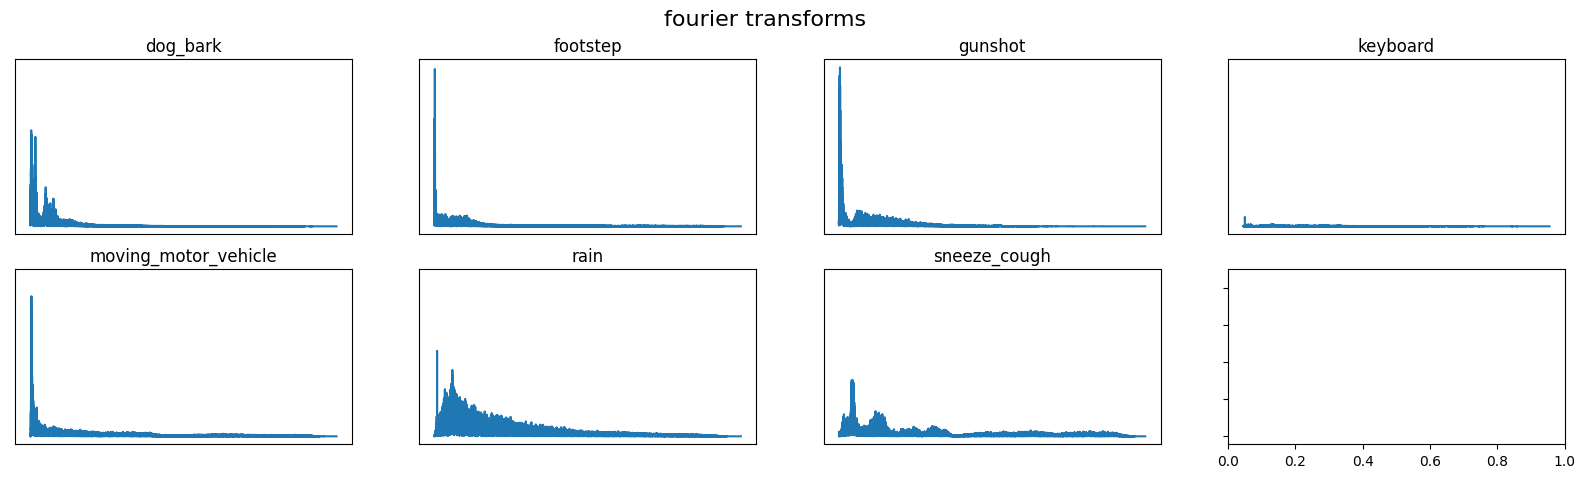

In [55]:
plot_fft(fft)
plt.show()

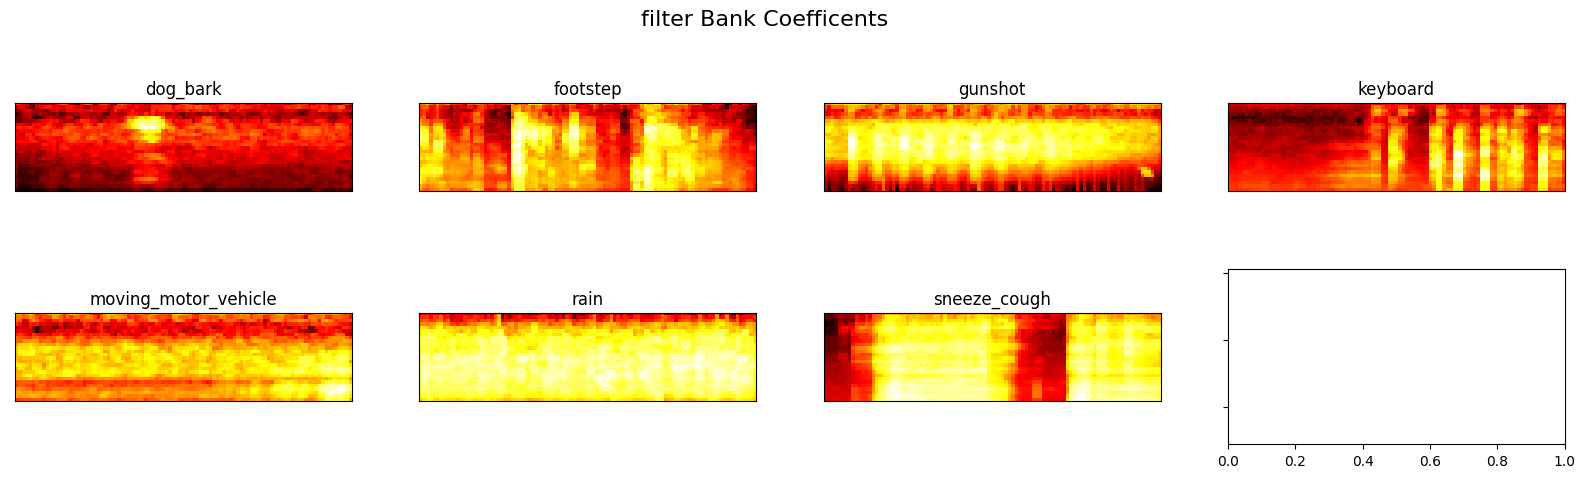

In [56]:
plot_fbank(fbank)
plt.show()

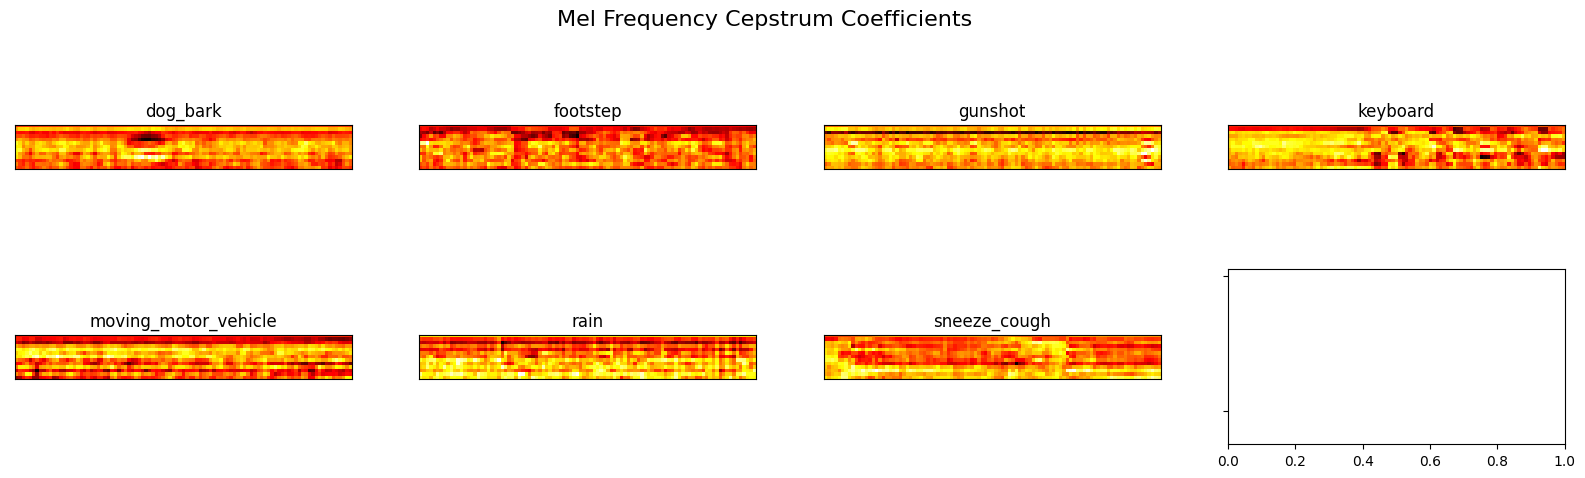

In [57]:
plot_mfccs(mfccs)
plt.show()

In [58]:
def envelope(y,rate,threshold):
    mask =[]
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window = int(rate/10),min_periods=1,center = True).mean()#rolling window = 10 of a seconde
    for mean in y_mean:
        if mean>threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask

In [60]:
for classe in classes:
    wav_F = df[df.label == classe].iloc[0,0]
    signal,rate = librosa.load(waveFile+'\\'+wav_F,sr = 22050)
    mask = envelope(signal,rate,0.0005)
    signal=signal[mask]
    signals[classe]=signal
    fft[classe] = calc_fft(signal,rate)
    
    bank = logfbank(signal[:rate],rate,nfilt = 26,nfft=551).T
    fbank[classe] =bank
    mel = mfcc(signal[:rate],rate,numcep=13,nfilt=26,nfft=551).T
    mfccs[classe]=mel

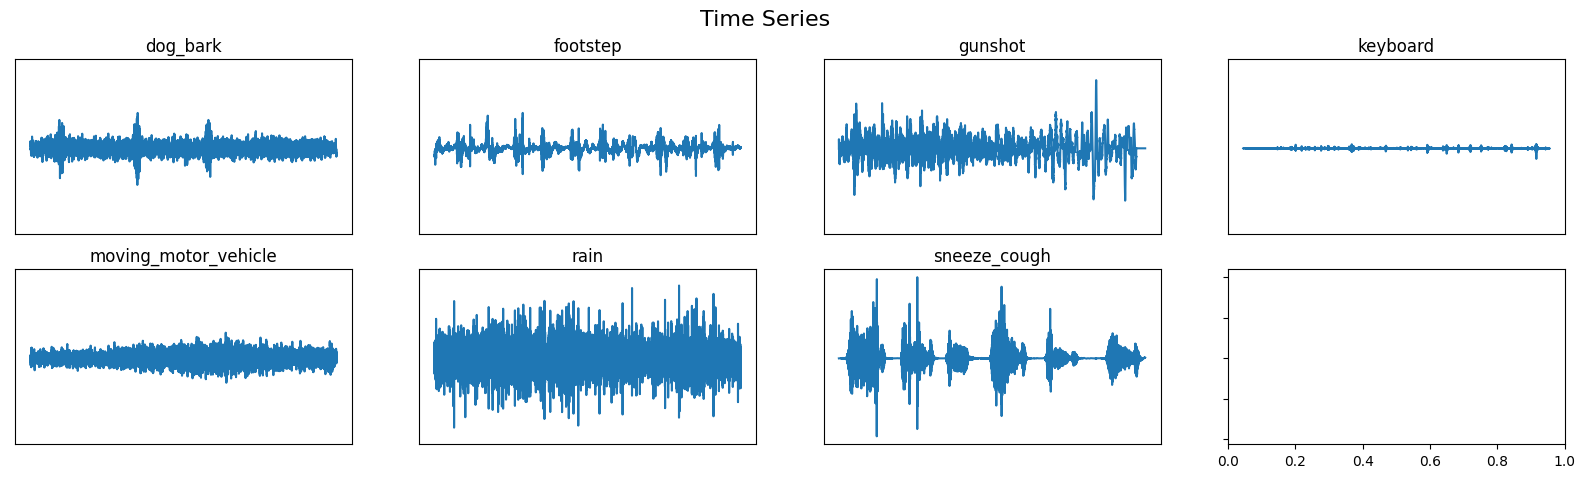

In [61]:
plot_signals(signals)
plt.show()

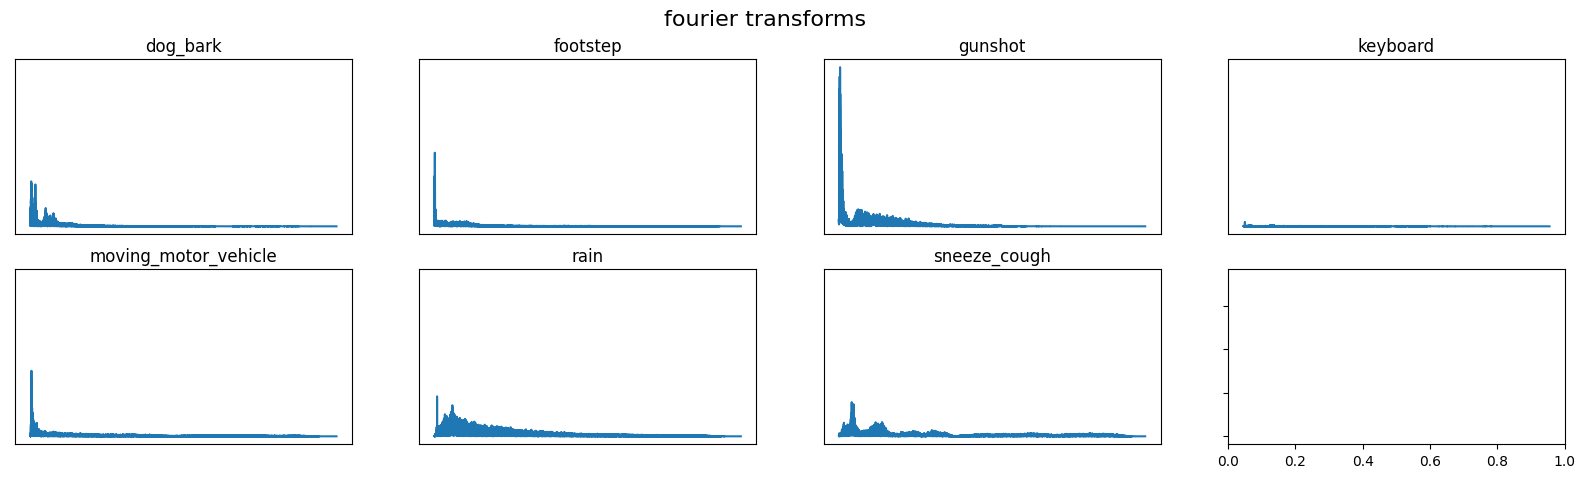

In [62]:
plot_fft(fft)
plt.show()

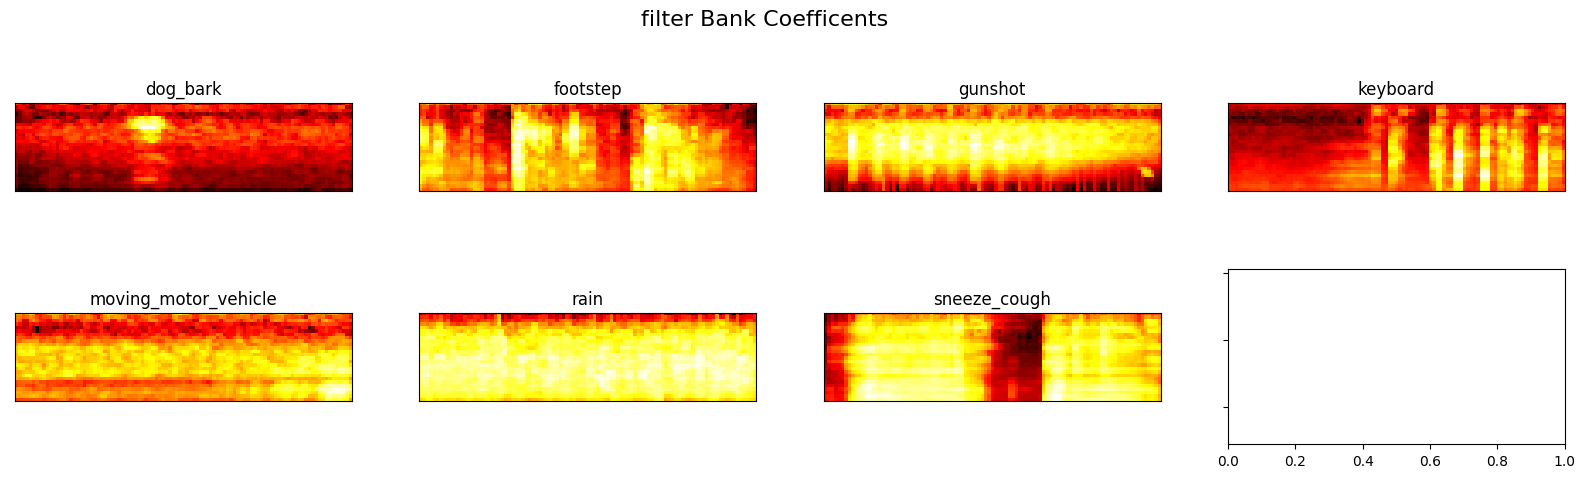

In [63]:
plot_fbank(fbank)
plt.show()

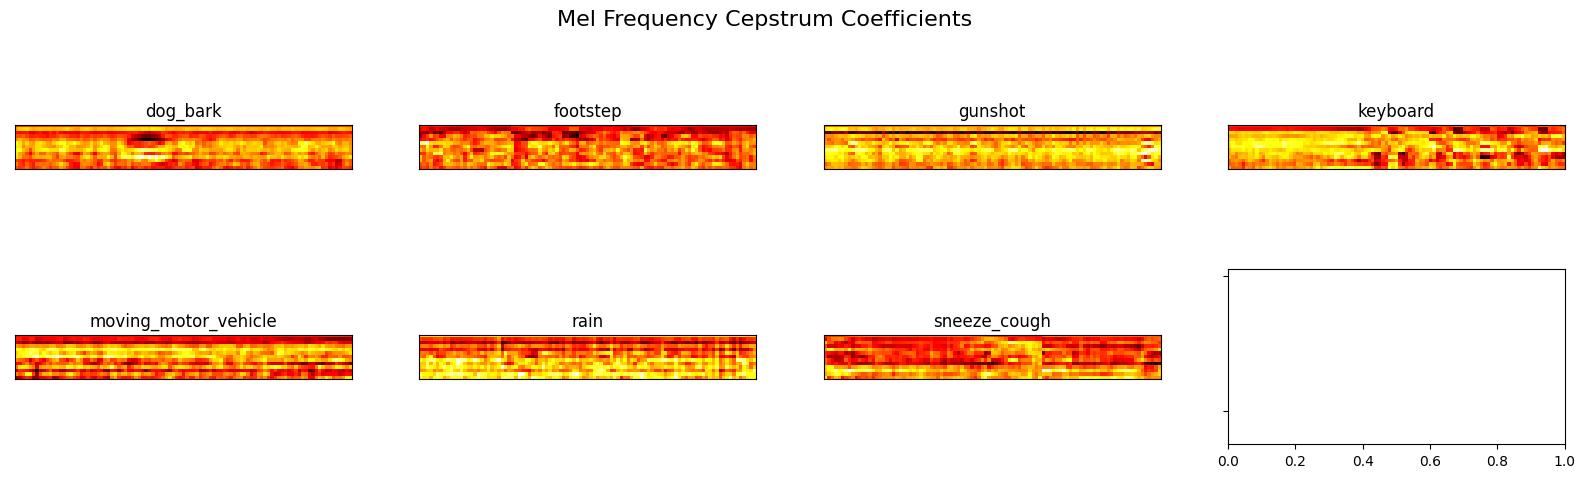

In [64]:
plot_mfccs(mfccs)
plt.show()

In [67]:
df.index

RangeIndex(start=0, stop=4850, step=1)

In [87]:
# if len(os.listdir(r"C:\Users\Saad KOUKOUS\Documents\Projet5A\DCASE_2023_Challenge_Task_7_Dataset\clean_dev"))==0:
for f in tqdm(df.index):
    signal,rate = librosa.load(waveFile+'\\'+f,sr = 16000)
    mask = envelope(signal,rate,0.0005
                    )
    wavfile.write(filename='DCASE_2023_Challenge_Task_7_Dataset\clean_dev\\'+f,rate=rate,data = signal[mask])

100%|██████████| 4850/4850 [06:44<00:00, 12.00it/s]
